# Loki Annotate - Bulk RNA-seq
This notebook demonstrates how to run *Loki Annotate* on the bulk RNA-seq dataset. It takes about 2 mins to run this notebook on MacBook Pro.

In [1]:
import pandas as pd
import os
import torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import loki.annotate
import loki.preprocess
import loki.utils
import loki.plot

/opt/anaconda3/envs/basic/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/basic/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


We provide the embeddings generated from the OmiCLIP model.
The sample data and embeddings are stored in the directory `data/loki_annotate/bulk_RNAseq_data`, which can be donwloaded from [Google Drive link](https://drive.google.com/file/d/1aPK1nItsOEPxTihUAKMig-vLY-DMMIce/view?usp=sharing).

Here is a list of the files that are needed to run the tissue annotation on example data:
```
.
├── adipose
│   ├── checkpoints
│   │   ├── bulk_adipose_txt_features_zeroshot.csv
│   │   ├── samplev02_img_features_zeroshot.csv
│   │   ├── samplev03_img_features_zeroshot.csv
│   │   └── samplev04_img_features_zeroshot.csv
│   └── image_data
│       ├── samplev02_coords.json
│       ├── samplev02_raw.h5ad
│       ├── samplev03_coords.json
│       ├── samplev03_raw.h5ad
│       ├── samplev04_coords.json
│       └── samplev04_raw.h5ad
├── fibroblast
│   ├── checkpoints
│   │   ├── FZ_P14_img_features_zeroshot.csv
│   │   ├── FZ_P18_img_features_zeroshot.csv
│   │   ├── FZ_P20_img_features_zeroshot.csv
│   │   └── bulk_fibroblast_txt_features_zeroshot.csv
│   └── image_data
│       ├── FZ_P14.tif
│       ├── FZ_P14_coords.json
│       ├── FZ_P14_raw.h5ad
│       ├── FZ_P18.tif
│       ├── FZ_P18_coords.json
│       ├── FZ_P18_raw.h5ad
│       ├── FZ_P20.tif
│       ├── FZ_P20_coords.json
│       └── FZ_P20_raw.h5ad
└── tumor
    ├── checkpoints
    │   ├── TCGA-A2-A0CL-01_image_embeddings.pt
    │   ├── TCGA-A2-A0CL-01_text_embeddings.pt
    │   ├── TCGA-A2-A0CW-01_image_embeddings.pt
    │   ├── TCGA-A2-A0CW-01_text_embeddings.pt
    │   ├── TCGA-AO-A0J5-01_image_embeddings.pt
    │   └── TCGA-AO-A0J5-01_text_embeddings.pt
    └── image_data
        ├── TCGA-A2-A0CL-01_coords.pt
        ├── TCGA-A2-A0CL-01_downsized.jpg
        ├── TCGA-A2-A0CW-01_coords.pt
        ├── TCGA-A2-A0CW-01_downsized.jpg
        ├── TCGA-AO-A0J5-01_coords.pt
        ├── TCGA-AO-A0J5-01_downsized.jpg
        └── polygons.json                                   
```

In [2]:
data_dir = '../data/loki_annotate/bulk_RNAseq_data/'

## Loki Annote with bulk RNA-seq data of tumor
Use Loki Annotate to annotate tumor cell enriched regions in 3 H&E images of breast cancer tissues.

### TCGA data

The TCGA breast cancer slide files can be downloaded from the GDC data portal. We provide the image files downsized by 32 times for visualization. 

The bulk RNA-seq data can be downloaded from cBioportal.

In [3]:
case_name = '_img_features_zeroshot'
sample_type = 'tumor'
slide_dict = {
        "TCGA-A2-A0CL-01": "TCGA-A2-A0CL-01Z-00-DX1.5342E971-DCD2-42C4-B4FF-E6942A95829E.svs",
        "TCGA-A2-A0CW-01": "TCGA-A2-A0CW-01Z-00-DX1.8E313A22-B0E8-44CF-ADEA-8BF29BA23FFE.svs",
        "TCGA-AO-A0J5-01": "TCGA-AO-A0J5-01Z-00-DX1.20C14D0C-1A74-4FE9-A5E6-BDDCB8DE7714.svs"
        }

TCGA-A2-A0CL-01


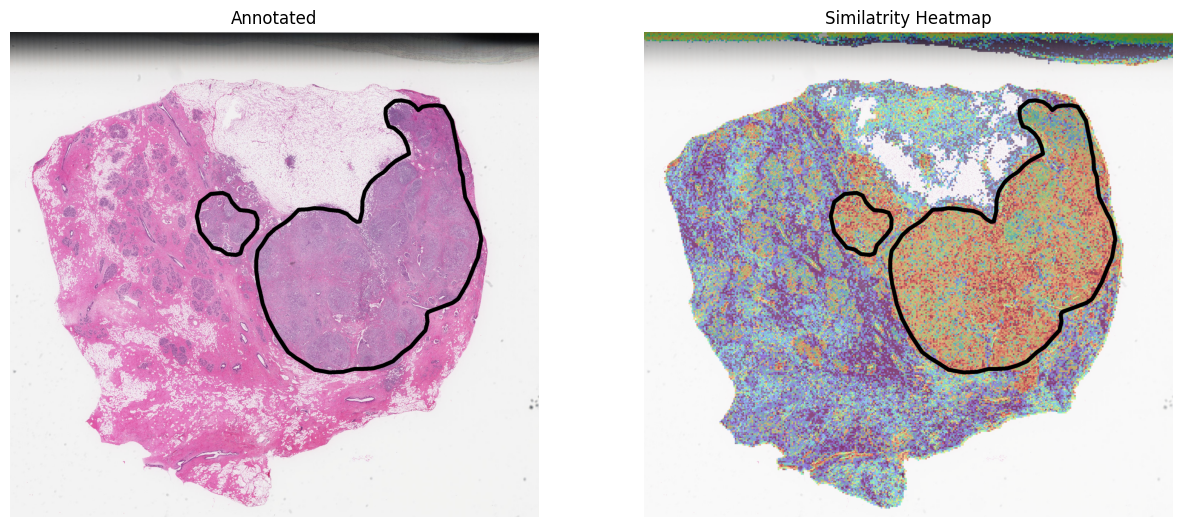

TCGA-A2-A0CW-01


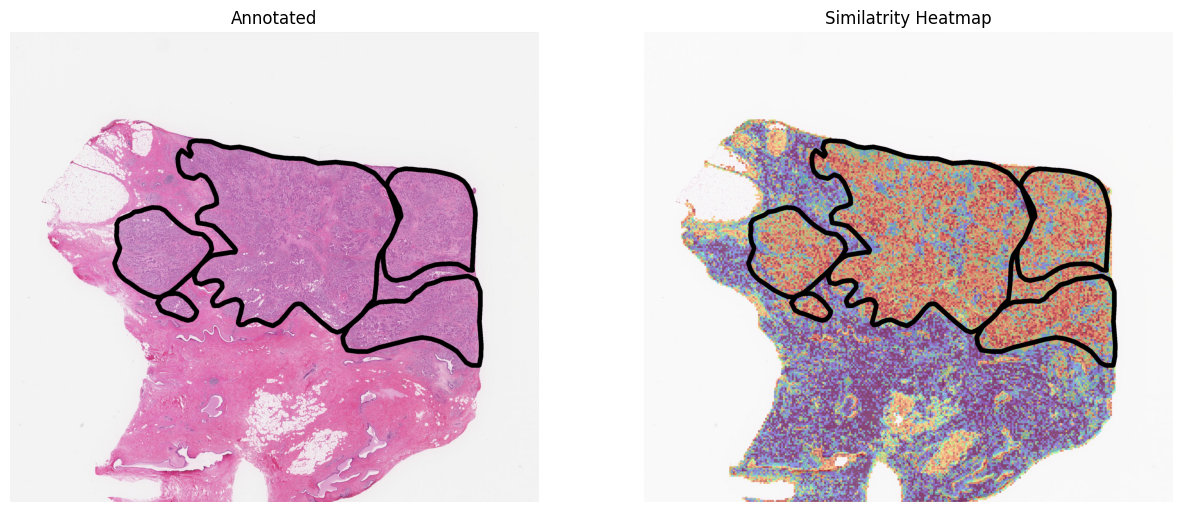

TCGA-AO-A0J5-01


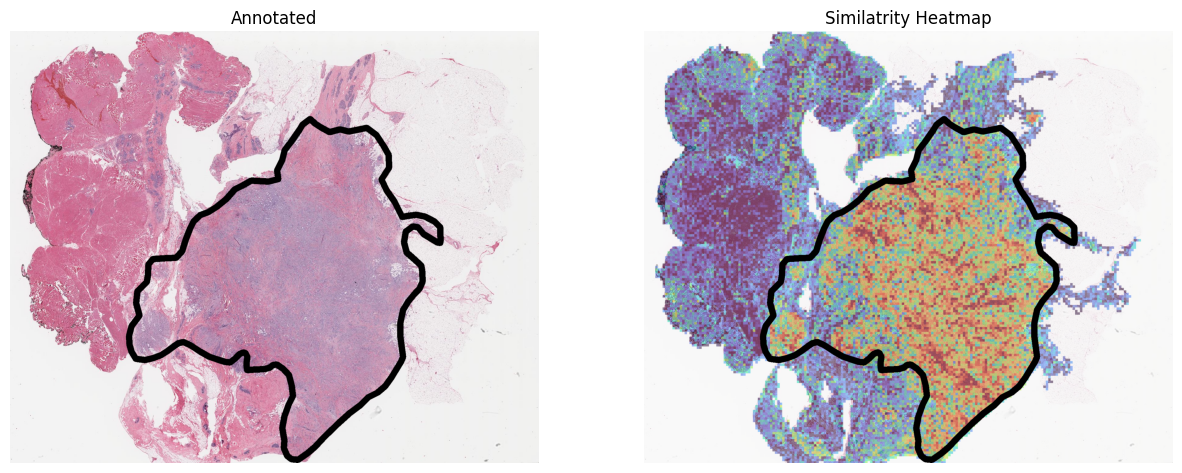

In [4]:
for case_id, slide_path in slide_dict.items():
    print(case_id)
    slide_id = Path(slide_path).stem
    image_path = os.path.join(data_dir, sample_type, 'image_data', case_id+'_downsized.jpg')
    coor_path = os.path.join(data_dir, sample_type, 'image_data', case_id+'_coords.pt')
    image_embedding_path = os.path.join(data_dir, sample_type, 'checkpoints', case_id+'_image_embeddings.pt')
    omic_embedding_path = os.path.join(data_dir, sample_type, 'checkpoints', case_id+'_text_embeddings.pt')

    coor = torch.load(coor_path)
    img_features = torch.load(image_embedding_path)  # Image embeddings (shape: [n, 768])
    bulk_features = torch.load(omic_embedding_path)   # Omic features (shape: [768])
    weight = loki.annotate.annotate_with_bulk(img_features, bulk_features, tensor=True)[0].squeeze().numpy()
    weight = loki.utils.cap_quantile(weight, cap_max=0.99, cap_min=0.1)
    polygon_config_path = os.path.join(data_dir, sample_type, 'image_data', 'polygons.json')

    polygons, polygons_color, polygons_thickness = loki.utils.read_polygons(polygon_config_path, slide_path)
    heatmap, image = loki.plot.plot_heatmap(
        coor,
        weight,
        image_path=image_path,
        patch_size=(256, 256),
        save_path=None,
        downsize=32,
        cmap='turbo',
        polygons=polygons,
        polygons_color=polygons_color,
        polygons_thickness=polygons_thickness,
        image_alpha=0.5
    )

    loki.plot.show_images_side_by_side(image, heatmap, title1='Annotated', title2='Similatrity Heatmap')
    

## Loki Annote with bulk RNA-seq data of fibroblast
Use Loki Annotate to annotate fibroblast cell enriched regions in 3 H&E images of heart failure tissues.

In [5]:
sample_type = 'fibroblast'
s=35
linewidth=5
xlim=[0,10000]
ylim=[0,10000]
bulk_text_feature = pd.read_csv(os.path.join(data_dir, sample_type, 'checkpoints', 'bulk_fibroblast_txt_features_zeroshot.csv'), index_col=0)

### Heart failure sample 1

In [6]:
sample_name = 'FZ_P20'
st_data_path = os.path.join(data_dir, sample_type, 'image_data', sample_name+'_raw.h5ad')
json_path = os.path.join(data_dir, sample_type, 'image_data', sample_name+'_coords.json')
st_ad, library_id, roi_polygon = loki.preprocess.load_data_for_annotation(st_data_path, json_path)

fullres_img_path = os.path.join(data_dir, sample_type, 'image_data', sample_name+'.tif')
fullres_img = Image.open(fullres_img_path)
img_feature_path = os.path.join(data_dir, sample_type, 'checkpoints', sample_name+case_name+'.csv')
img_feature = pd.read_csv(img_feature_path, index_col=0)

/opt/anaconda3/envs/basic/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/basic/lib/python3.9/site-packages/loki/preprocess.py:282: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  st_ad.obs[["pixel_y", "pixel_x"]] = None  # Ensure the columns exist
/opt/anaconda3/envs/basic/lib/python3.9/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (93006507 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [7]:
loki.plot.plot_img_with_annotation(fullres_img, roi_polygon, linewidth, xlim, ylim)
plt.savefig(os.path.join(data_dir, sample_type, sample_name+'_fullres.jpg'))
plt.close()

In [8]:
st_ad.obs['bulk_simi'] = loki.annotate.annotate_with_bulk(img_feature, bulk_text_feature)

In [9]:
loki.plot.plot_annotation_heatmap(st_ad, roi_polygon, s, linewidth, xlim, ylim)
plt.savefig(os.path.join(data_dir, sample_type, sample_name+'_heatmap.jpg'))
plt.close()

In [10]:
image_path = os.path.join(data_dir, sample_type, sample_name+'_fullres.jpg')
image = loki.annotate.load_image_annotation(image_path)

heatmap_path = os.path.join(data_dir, sample_type, sample_name+'_heatmap.jpg')
heatmap = loki.annotate.load_image_annotation(heatmap_path)
heatmap = loki.plot.blend_images(heatmap, image)

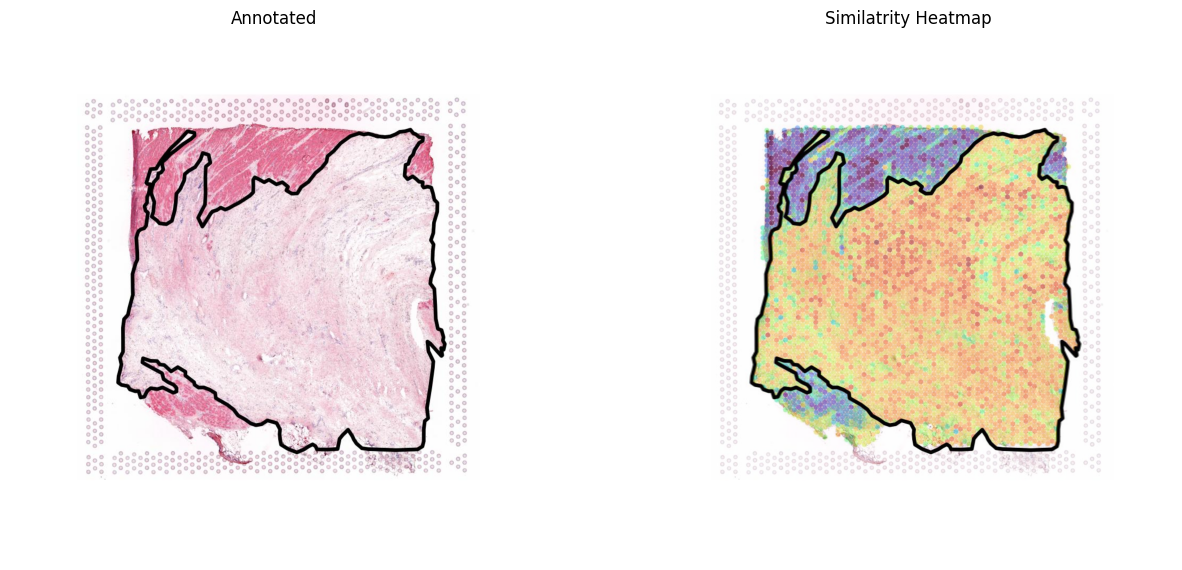

In [11]:
loki.plot.show_images_side_by_side(image, heatmap, title1='Annotated', title2='Similatrity Heatmap')

### Heart failure sample 2

In [12]:
sample_name = 'FZ_P18'
st_data_path = os.path.join(data_dir, sample_type, 'image_data', sample_name+'_raw.h5ad')
json_path = os.path.join(data_dir, sample_type, 'image_data', sample_name+'_coords.json')
st_ad, library_id, roi_polygon = loki.preprocess.load_data_for_annotation(st_data_path, json_path)

fullres_img_path = os.path.join(data_dir, sample_type, 'image_data', sample_name+'.tif')
fullres_img = Image.open(fullres_img_path)
img_feature_path = os.path.join(data_dir, sample_type, 'checkpoints', sample_name+case_name+'.csv')
img_feature = pd.read_csv(img_feature_path, index_col=0)

/opt/anaconda3/envs/basic/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/basic/lib/python3.9/site-packages/loki/preprocess.py:282: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  st_ad.obs[["pixel_y", "pixel_x"]] = None  # Ensure the columns exist
/opt/anaconda3/envs/basic/lib/python3.9/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (96294069 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [13]:
loki.plot.plot_img_with_annotation(fullres_img, roi_polygon, linewidth, xlim, ylim)
plt.savefig(os.path.join(data_dir, sample_type, sample_name+'_fullres.jpg'))
plt.close()

In [14]:
st_ad.obs['bulk_simi'] = loki.annotate.annotate_with_bulk(img_feature, bulk_text_feature)

In [15]:
loki.plot.plot_annotation_heatmap(st_ad, roi_polygon, s, linewidth, xlim, ylim)
plt.savefig(os.path.join(data_dir, sample_type, sample_name+'_heatmap.jpg'))
plt.close()

In [16]:
image_path = os.path.join(data_dir, sample_type, sample_name+'_fullres.jpg')
image = loki.annotate.load_image_annotation(image_path)

heatmap_path = os.path.join(data_dir, sample_type, sample_name+'_heatmap.jpg')
heatmap = loki.annotate.load_image_annotation(heatmap_path)
heatmap = loki.plot.blend_images(heatmap, image)

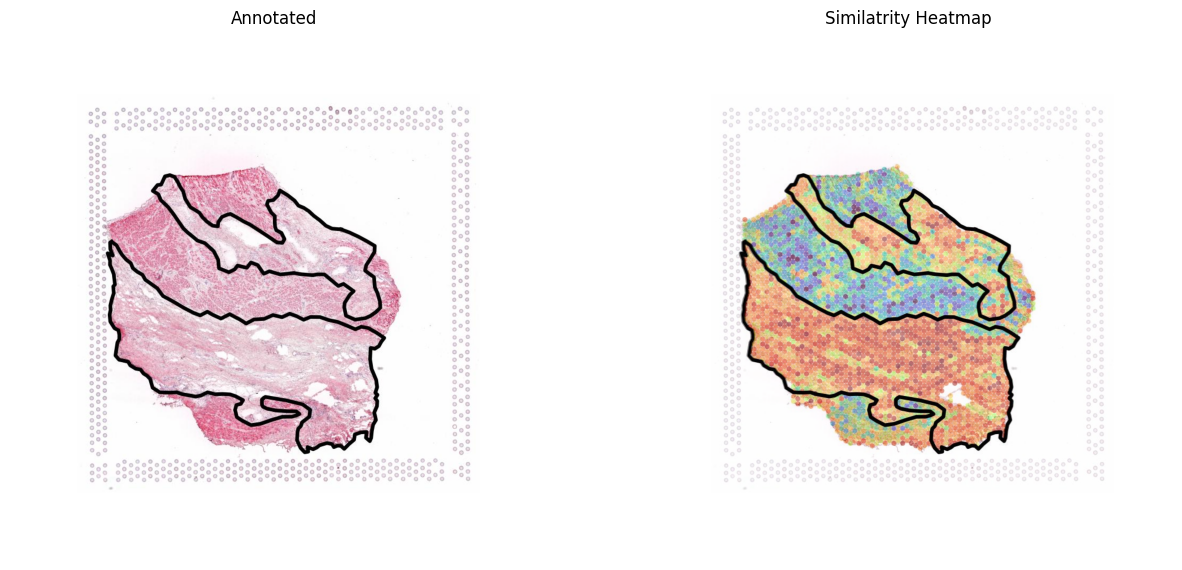

In [17]:
loki.plot.show_images_side_by_side(image, heatmap, title1='Annotated', title2='Similatrity Heatmap')

### Heart failure sample 3

In [18]:
sample_name = 'FZ_P14'
st_data_path = os.path.join(data_dir, sample_type, 'image_data', sample_name+'_raw.h5ad')
json_path = os.path.join(data_dir, sample_type, 'image_data', sample_name+'_coords.json')
st_ad, library_id, roi_polygon = loki.preprocess.load_data_for_annotation(st_data_path, json_path, in_tissue=False)

fullres_img_path = os.path.join(data_dir, sample_type, 'image_data', sample_name+'.tif')
fullres_img = Image.open(fullres_img_path)
img_feature_path = os.path.join(data_dir, sample_type, 'checkpoints', sample_name+case_name+'.csv')
img_feature = pd.read_csv(img_feature_path, index_col=0)

/opt/anaconda3/envs/basic/lib/python3.9/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (94551858 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [19]:
loki.plot.plot_img_with_annotation(fullres_img, roi_polygon, linewidth, xlim, ylim)
plt.savefig(os.path.join(data_dir, sample_type, sample_name+'_fullres.jpg'))
plt.close()

In [20]:
st_ad.obs['bulk_simi'] = loki.annotate.annotate_with_bulk(img_feature, bulk_text_feature)

In [21]:
loki.plot.plot_annotation_heatmap(st_ad, roi_polygon, s, linewidth, xlim, ylim)
plt.savefig(os.path.join(data_dir, sample_type, sample_name+'_heatmap.jpg'))
plt.close()

In [22]:
image_path = os.path.join(data_dir, sample_type, sample_name+'_fullres.jpg')
image = loki.annotate.load_image_annotation(image_path)

heatmap_path = os.path.join(data_dir, sample_type, sample_name+'_heatmap.jpg')
heatmap = loki.annotate.load_image_annotation(heatmap_path)
heatmap = loki.plot.blend_images(heatmap, image)

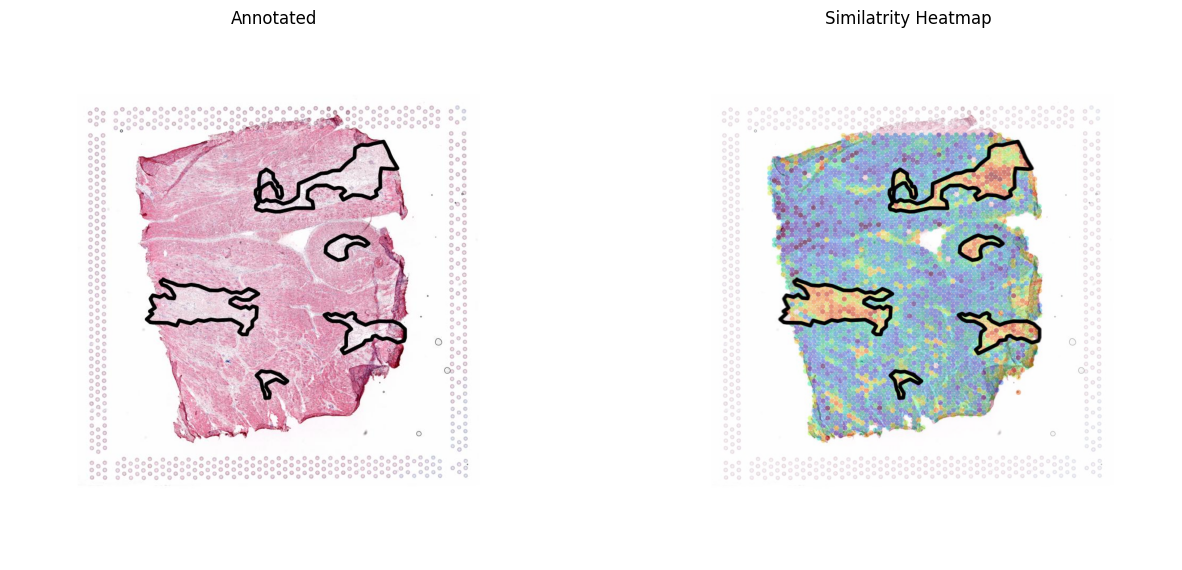

In [23]:
loki.plot.show_images_side_by_side(image, heatmap, title1='Annotated', title2='Similatrity Heatmap')

## Loki Annote with bulk RNA-seq data of adipose
Use Loki Annotate to annotate adipose cell enriched regions in 3 H&E images of normal breast tissues.

In [24]:
sample_type = 'adipose'
bulk_text_feature = pd.read_csv(os.path.join(data_dir, sample_type, 'checkpoints', 'bulk_adipose_txt_features_zeroshot.csv'), index_col=0)

### Breast sample 1

In [25]:
sample_name = 'samplev02'
st_data_path = os.path.join(data_dir, sample_type, 'image_data', sample_name+'_raw.h5ad')
json_path = os.path.join(data_dir, sample_type, 'image_data', sample_name+'_coords.json')
st_ad, library_id, roi_polygon = loki.preprocess.load_data_for_annotation(st_data_path, json_path)

fullres_img = st_ad.uns['spatial'][library_id]['images']['fullres']
img_feature_path = os.path.join(data_dir, sample_type, 'checkpoints', sample_name+case_name+'.csv')
img_feature = pd.read_csv(img_feature_path, index_col=0)

/opt/anaconda3/envs/basic/lib/python3.9/site-packages/loki/preprocess.py:282: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  st_ad.obs[["pixel_y", "pixel_x"]] = None  # Ensure the columns exist


In [26]:
s=50
linewidth=4
xlim=[0,4000]
ylim=[0,4000]
loki.plot.plot_img_with_annotation(fullres_img, roi_polygon, linewidth, xlim, ylim)
plt.savefig(os.path.join(data_dir, sample_type, sample_name+'_fullres.jpg'))
plt.close()

In [27]:
st_ad.obs['bulk_simi'] = loki.annotate.annotate_with_bulk(img_feature, bulk_text_feature)

In [28]:
loki.plot.plot_annotation_heatmap(st_ad, roi_polygon, s, linewidth, xlim, ylim)
plt.savefig(os.path.join(data_dir, sample_type, sample_name+'_heatmap.jpg'))
plt.close()

In [29]:
image_path = os.path.join(data_dir, sample_type, sample_name+'_fullres.jpg')
image = loki.annotate.load_image_annotation(image_path)

heatmap_path = os.path.join(data_dir, sample_type, sample_name+'_heatmap.jpg')
heatmap = loki.annotate.load_image_annotation(heatmap_path)
heatmap = loki.plot.blend_images(heatmap, image)

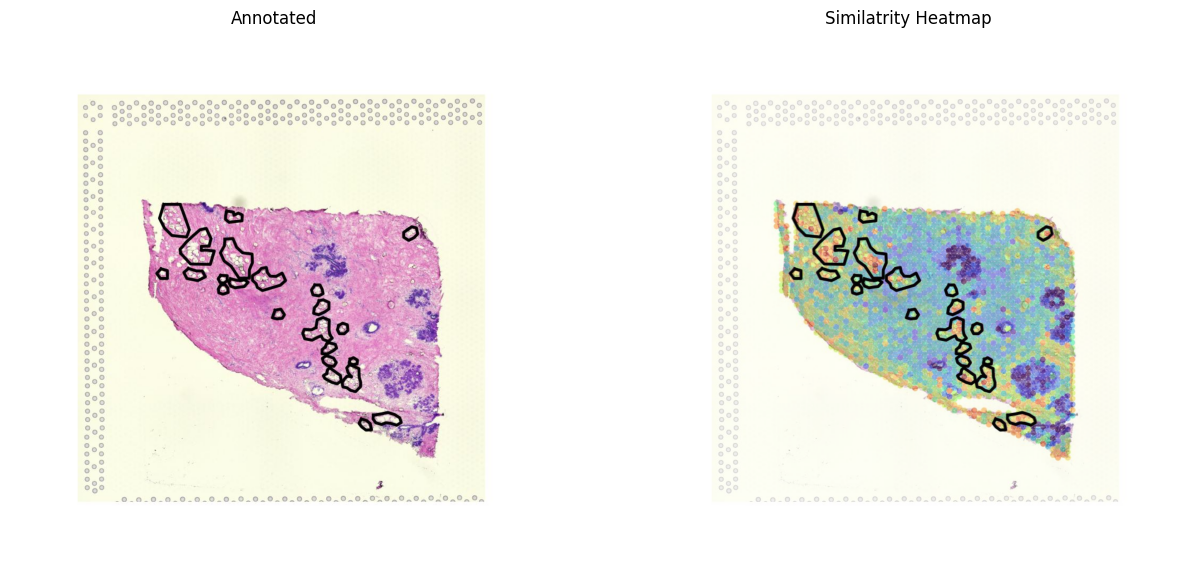

In [30]:
loki.plot.show_images_side_by_side(image, heatmap, title1='Annotated', title2='Similatrity Heatmap')

### Breast sample 2

In [31]:
sample_name = 'samplev03'
st_data_path = os.path.join(data_dir, sample_type, 'image_data', sample_name+'_raw.h5ad')
json_path = os.path.join(data_dir, sample_type, 'image_data', sample_name+'_coords.json')
st_ad, library_id, roi_polygon = loki.preprocess.load_data_for_annotation(st_data_path, json_path)

fullres_img = st_ad.uns['spatial'][library_id]['images']['fullres']
img_feature_path = os.path.join(data_dir, sample_type, 'checkpoints', sample_name+case_name+'.csv')
img_feature = pd.read_csv(img_feature_path, index_col=0)

/opt/anaconda3/envs/basic/lib/python3.9/site-packages/loki/preprocess.py:282: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  st_ad.obs[["pixel_y", "pixel_x"]] = None  # Ensure the columns exist


In [32]:
s=55
linewidth=4
xlim=[1500,21000]
ylim=[1500,21000]
loki.plot.plot_img_with_annotation(fullres_img, roi_polygon, linewidth, xlim, ylim)
plt.savefig(os.path.join(data_dir, sample_type, sample_name+'_fullres.jpg'))
plt.close()

In [33]:
st_ad.obs['bulk_simi'] = loki.annotate.annotate_with_bulk(img_feature, bulk_text_feature)

In [34]:
loki.plot.plot_annotation_heatmap(st_ad, roi_polygon, s, linewidth, xlim, ylim)
plt.savefig(os.path.join(data_dir, sample_type, sample_name+'_heatmap.jpg'))
plt.close()

In [35]:
image_path = os.path.join(data_dir, sample_type, sample_name+'_fullres.jpg')
image = loki.annotate.load_image_annotation(image_path)

heatmap_path = os.path.join(data_dir, sample_type, sample_name+'_heatmap.jpg')
heatmap = loki.annotate.load_image_annotation(heatmap_path)
heatmap = loki.plot.blend_images(heatmap, image)

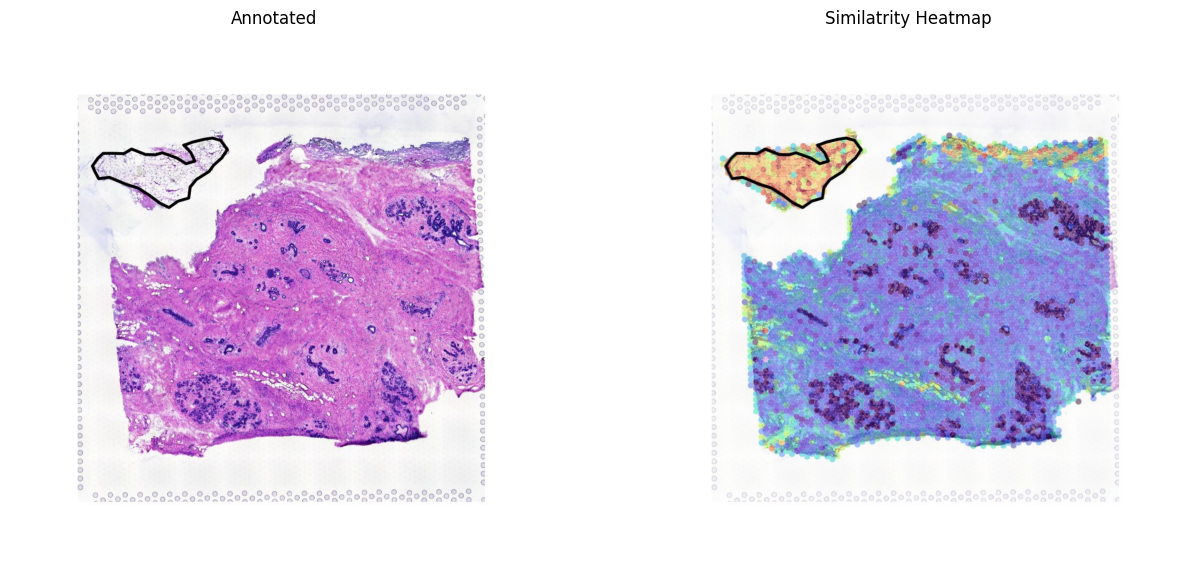

In [36]:
loki.plot.show_images_side_by_side(image, heatmap, title1='Annotated', title2='Similatrity Heatmap')

### Breast sample 3

In [37]:
sample_name = 'samplev04'
st_data_path = os.path.join(data_dir, sample_type, 'image_data', sample_name+'_raw.h5ad')
json_path = os.path.join(data_dir, sample_type, 'image_data', sample_name+'_coords.json')
st_ad, library_id, roi_polygon = loki.preprocess.load_data_for_annotation(st_data_path, json_path)

fullres_img = st_ad.uns['spatial'][library_id]['images']['fullres']
img_feature_path = os.path.join(data_dir, sample_type, 'checkpoints', sample_name+case_name+'.csv')
img_feature = pd.read_csv(img_feature_path, index_col=0)

/opt/anaconda3/envs/basic/lib/python3.9/site-packages/loki/preprocess.py:282: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  st_ad.obs[["pixel_y", "pixel_x"]] = None  # Ensure the columns exist


In [38]:
s=55
linewidth=5
xlim=[2000,21000]
ylim=[2000,21000]
loki.plot.plot_img_with_annotation(fullres_img, roi_polygon, linewidth, xlim, ylim)
plt.savefig(os.path.join(data_dir, sample_type, sample_name+'_fullres.jpg'))
plt.close()

In [39]:
st_ad.obs['bulk_simi'] = loki.annotate.annotate_with_bulk(img_feature, bulk_text_feature)

In [40]:
loki.plot.plot_annotation_heatmap(st_ad, roi_polygon, s, linewidth, xlim, ylim)
plt.savefig(os.path.join(data_dir, sample_type, sample_name+'_heatmap.jpg'))
plt.close()

In [41]:
image_path = os.path.join(data_dir, sample_type, sample_name+'_fullres.jpg')
image = loki.annotate.load_image_annotation(image_path)

heatmap_path = os.path.join(data_dir, sample_type, sample_name+'_heatmap.jpg')
heatmap = loki.annotate.load_image_annotation(heatmap_path)
heatmap = loki.plot.blend_images(heatmap, image)

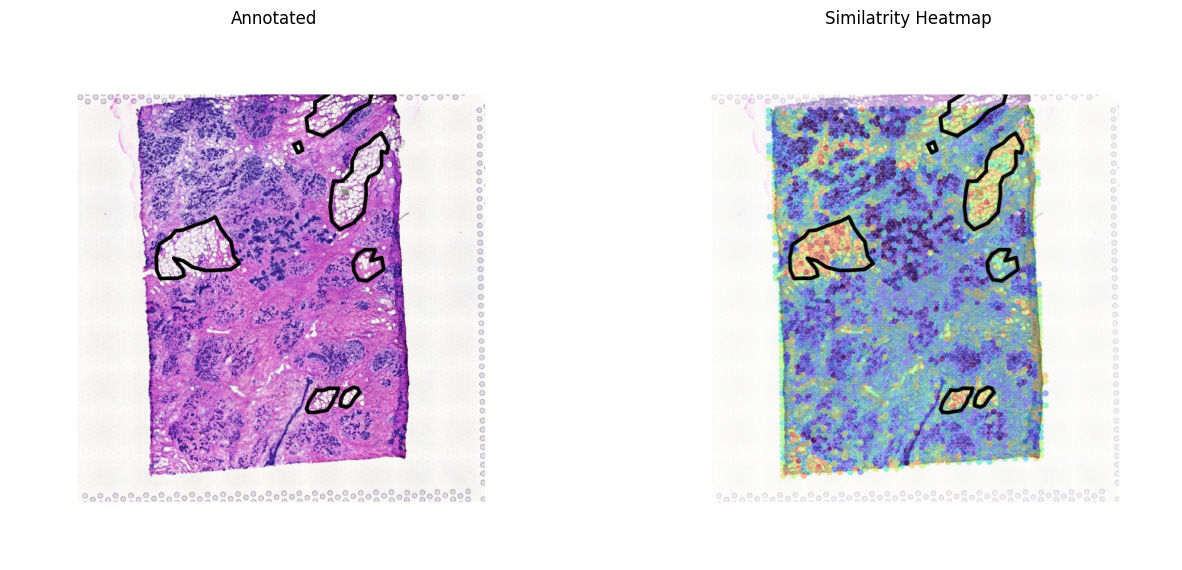

In [42]:
loki.plot.show_images_side_by_side(image, heatmap, title1='Annotated', title2='Similatrity Heatmap')